# Core Workflow: Preparing Ground-truth Files
Transforms the LULC polygons provided by the Atlas of Urban Expansion into raster data that can be combined with imagery and/or other remote sensing inputs to create machine learning training data.  
  
Date: 2018-09-14  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [5]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '$ULU_REPO/utils', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

# replace with sentinel-2 ids from the project imagery catalog
# any list of image ids is fine, provided that collectively it covers the full study area
vir_ids = [u'sentinel-2:L1C:2016-01-10_43QHV_97_S2A_v1']

tile_resolution = 10
tile_size = 256
tile_pad = 16

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

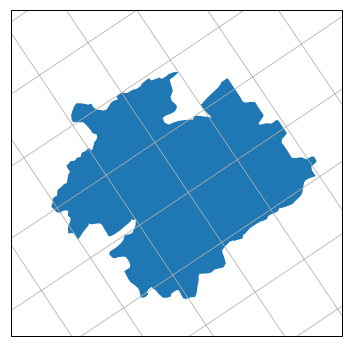

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.1775006012039, 17.529165535205387], [78.20460181878519, 17.52954978485592], [78.20420289377427, 17.555551127046854], [78.17709782110293, 17.55516627151902], [78.1775006012039, 17.529165535205387]]]}


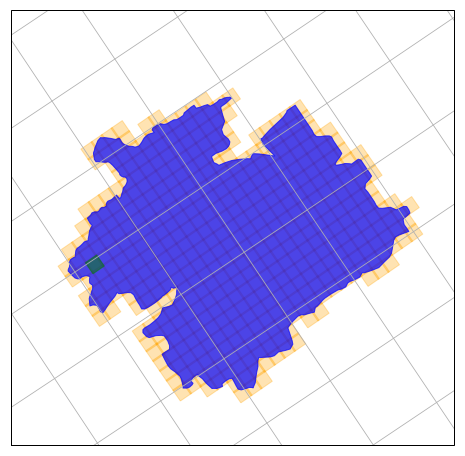

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Create ground-truth raster tiles
For each tile, creates a blank GeoTiff file and subsequently "burns" into it values from the (already prepared) GeoJSON file holding the AUE LULC polygons, thereby "rasterizing" the vector ground-truth data into a format amenable to machine learning: individual pixels in imagery can now be associated with specific LULC categories.

In [5]:
for tile_id in range(len(tiles['features'])):
    tile = tiles['features'][tile_id]
    util_descartes.make_label_raster(data_path, place, tile_id, tile, vir_ids, shape,
        bands=['alpha'], label_suffix='aue', vector_format='geojson')

imgfile /data/phase_iii/hyderabad/hyderabad_tile000_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile000_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile001_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile001_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile002_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile002_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile003_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile00

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile031_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile031_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile032_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile032_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile033_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile033_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile034_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile062_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile062_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile063_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile063_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile064_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile064_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile065_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile093_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile093_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile094_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile094_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile095_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile095_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile096_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile124_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile125_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile125_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile126_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile126_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile127_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile127_aue.tif
0...10...20...30...40...50...60...70...80...90

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile156_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile156_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile157_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile157_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile158_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile158_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile159_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile187_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile188_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile188_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile189_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile189_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile190_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile190_aue.tif
0...10...20...30...40...50...60...70...80...90

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile219_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile219_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile220_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile220_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile221_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile221_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile222_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile250_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile250_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile251_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile251_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile252_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile252_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile253_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile281_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile281_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile282_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile282_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile283_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile283_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile284_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile312_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile312_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile313_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile313_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile314_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile314_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile315_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile343_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile343_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile344_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile344_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile345_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile345_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile346_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile374_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile374_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile375_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile375_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile376_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile376_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile377_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile405_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile405_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile406_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile406_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile407_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile407_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile408_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab

0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile436_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile436_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile437_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile437_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile438_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderabad_Complete.geojson /data/phase_iii/hyderabad/hyderabad_tile438_aue.tif
0...10...20...30...40...50...60...70...80...90...100 - done.

imgfile /data/phase_iii/hyderabad/hyderabad_tile439_aue
>>> gdal_rasterize -a Land_use -l OGRGeoJSON /data/phase_iii/hyderabad/Hyderab